<a href="https://colab.research.google.com/github/MinhVuong2000/Data-Science/blob/master/FruitClassificationProject_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State problem
Use Deep Learning and [this dataset](https://www.kaggle.com/moltean/fruits) to predict kind of fruit as the given
image. This project should follow the guideline as:
1. Perform data exploration (group images, do clustering
analysis for images, display images for analysis, etc.).
2. Use CNN with classification_report to do prediction.
3. Use RNN with classification_report to do prediction.
4. Tune the models if necessary.
5. Use separate test set images to verify model accuracy.
6. Write up analysis to compare CNN vs. RNN.

#Import data

In [1]:
!import file from kaggle
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d moltean/fruits
!ls

/bin/bash: import: command not found


Saving kaggle.json to kaggle.json
 99% 753M/760M [00:04<00:00, 137MB/s]
100% 760M/760M [00:04<00:00, 166MB/s]
fruits.zip  kaggle.json  sample_data


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('fruits.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
!ls files

fruits-360


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Analysis data

In [4]:
train_path = "files/fruits-360/Training/"
test_path = "files/fruits-360/Test/"

classes = glob(train_path + "/*")
classes = [i.split('/')[-1] for i in classes]
number_classes = len(classes)

numberOfImagesTrain = len(glob(train_path + "/*/*"))
numberOfImagesTest = len(glob(test_path + "/*/*"))
print("Number of images in Train Data ",numberOfImagesTrain)
print("Number of images in Test Data ",numberOfImagesTest)
print('Number of classes: ',number_classes)

Number of images in Train Data  67692
Number of images in Test Data  22688
Number of classes:  131


So, dataset have 67692 images in training directory and 22688 images in testing directory. And there is all 131 classes

In [5]:
#show number in each class
numberOfImagesinClass = []
for i in classes:
  imagesInClass = glob(train_path + i + "/*")
  numberOfImagesinClass.append(len(imagesInClass))

from operator import itemgetter
dictData = dict(sorted(dict(zip(classes,numberOfImagesinClass)).items(), key=itemgetter(1)))
data = pd.DataFrame(dictData.items(), columns=['Class', 'Sum of Images']) 
data

Class  Sum of Images
0           Ginger Root            297
1           Pear Kaiser            300
2             Mangostan            300
3         Tomato Maroon            367
4         Cucumber Ripe            392
..                  ...            ...
126    Strawberry Wedge            738
127  Melon Piel de Sapo            738
128            Cherry 2            738
129              Plum 3            900
130          Grape Blue            984

[131 rows x 2 columns]

In [6]:
data.describe()

Sum of Images
count     131.000000
mean      516.732824
std       107.093620
min       297.000000
25%       471.000000
50%       490.000000
75%       492.000000
max       984.000000

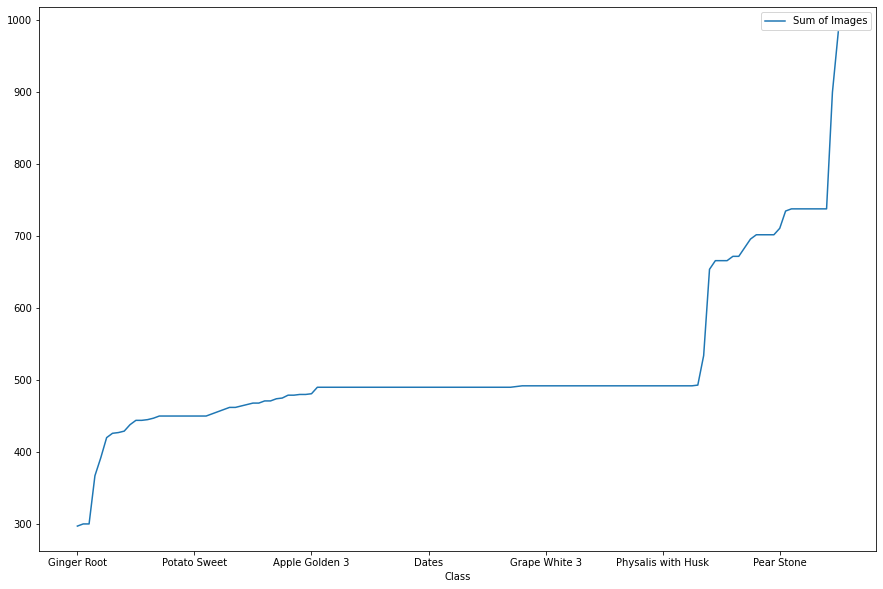

In [7]:
data.plot(x ='Class', y='Sum of Images', kind = 'line', figsize=(15,10))
plt.show()

From dataframe, there is 131 classes, include class Ginger Root is fewest images and class Grape Blue is the most. Number of images in almost classes (over 75%) is less than 500 pics.

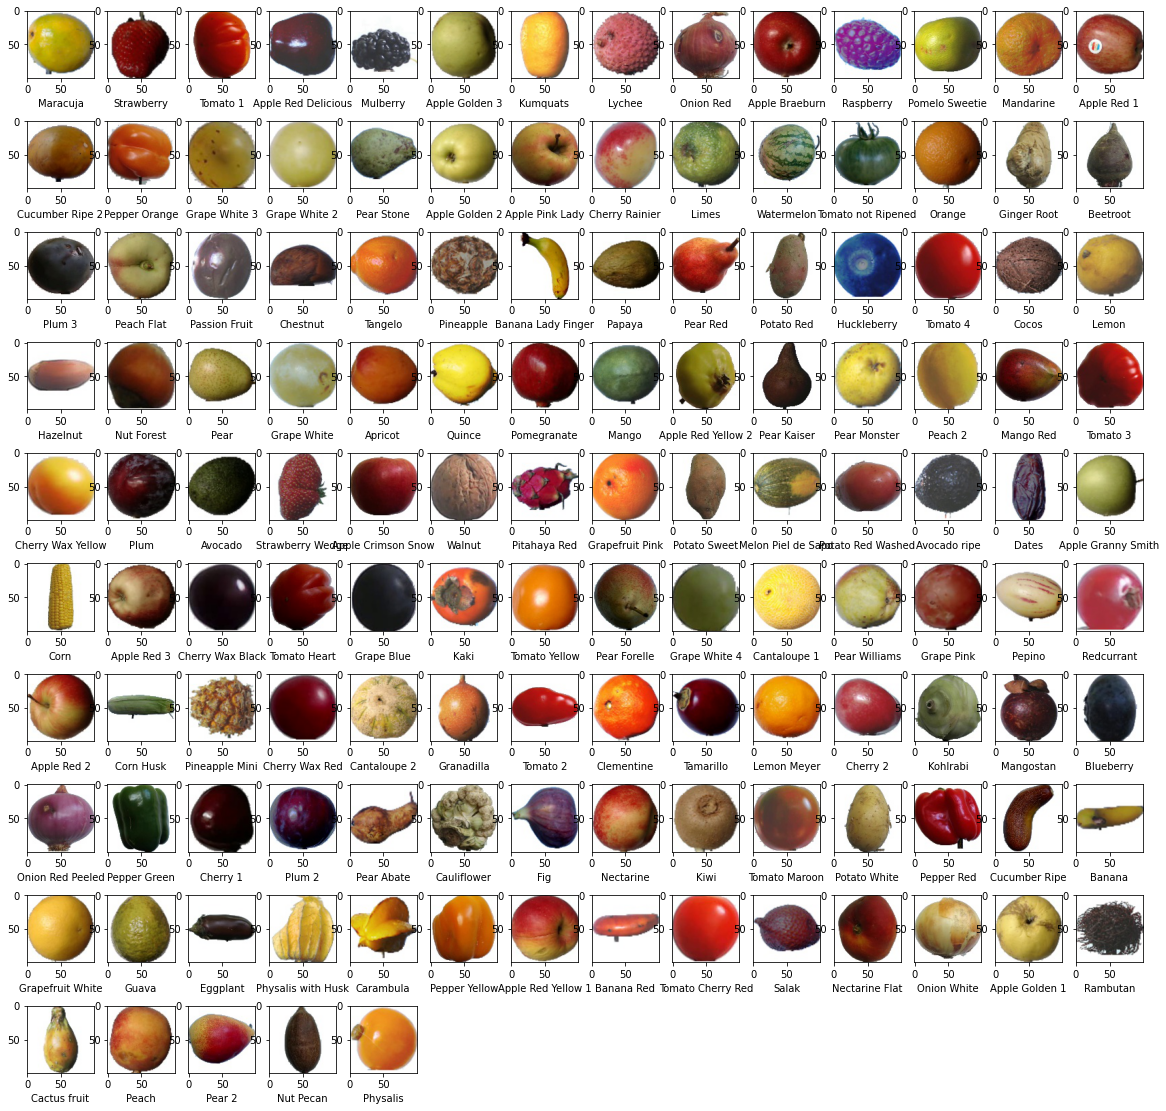

In [8]:
plt.figure(figsize = (20,20))
for i in range (number_classes):
  plt.subplot(10,number_classes//10+1,i+1)
  img = load_img(glob(train_path + classes[i] + "/*")[0])
  plt.imshow(img)
  plt.axis("on")
  plt.xlabel(classes[i])
  plt.grid(False)
plt.show()

In [9]:
x = img_to_array(load_img(glob(train_path + classes[0] + "/*")[0]))
print("Shape image to array: ",x.shape)

Shape image to array:  (100, 100, 3)


# Create CNN model

In [10]:
#CNN Model
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape = x.shape))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())

#display the architecture of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
____________________________________________________

In [11]:
#Add Dense layers on top
model.add(Flatten()) #3D to 1D
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3)) #avoid over-fitting
model.add(Dense(number_classes, activation = 'softmax')) #output
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

In [12]:
#Compile and train the model
model.compile(loss = "categorical_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

batch_size = 32

#Data Augmentation: tăng cường dữ liệu
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.3, 
                                   horizontal_flip=True, 
                                   zoom_range=0.3)
val_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range = 30)

train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size = x.shape[:2], 
                                                    batch_size = batch_size,
                                                    shuffle=True, 
                                                    color_mode='rgb')                             
val_generator = val_datagen.flow_from_directory(train_path, 
                                                target_size = x.shape[:2], 
                                                batch_size = batch_size,
                                                shuffle=True, 
                                                color_mode='rgb')

#Model Training
hist = model.fit_generator(generator = train_generator,
                    steps_per_epoch = train_generator.samples // batch_size, 
                    epochs = 5,
                    validation_data = val_generator,
                    validation_steps = val_generator.samples // batch_size)

#Saving model and weight
model.save("cnnModelFuit360")
model.save_weights("cnnModelFuit360_weight.h5")

Found 67692 images belonging to 131 classes.
Found 67692 images belonging to 131 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
2115/2115 [==============================] - 334s 155ms/step - loss: 2.1285 - accuracy: 0.4512 - val_loss: 0.1938 - val_accuracy: 0.9306
Epoch 2/5
2115/2115 [==============================] - 322s 152ms/step - loss: 0.2471 - accuracy: 0.9191 - val_loss: 0.1123 - val_accuracy: 0.9688
Epoch 3/5
2115/2115 [==============================] - 321s 152ms/step - loss: 0.1512 - accuracy: 0.9519 - val_loss: 0.1404 - val_accuracy: 0.9628
Epoch 4/5
2115/2115 [==============================] - 320s 151ms/step - loss: 0.1190 - accuracy: 0.9647 - val_loss: 0.1000 - val_accuracy: 0.9761
Epoch 5/5
2115/2115 [==============================] - 320s 151ms/step - loss: 0.1093 - accuracy: 0.9698 - val_loss: 0.1117 - val_accuracy: 0.9725
INFO:tensorflow:Assets written to: cnnModelFuit360/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


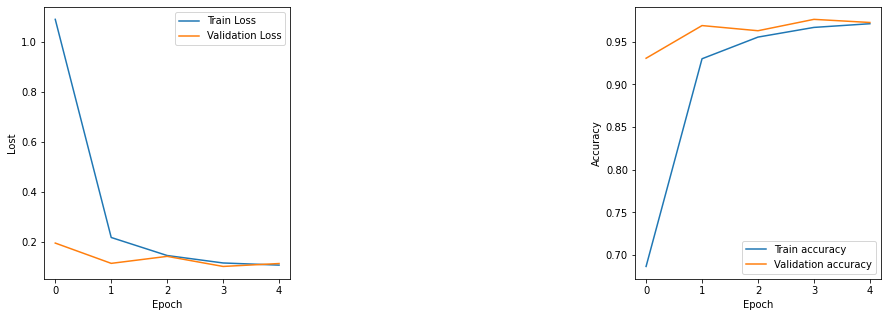

In [13]:
#Model Evaluation
print(hist.history.keys())

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(hist.history["loss"],label = "Train Loss")
plt.plot(hist.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Lost')

plt.subplot(1,3,3)
plt.plot(hist.history["accuracy"],label = "Train accuracy")
plt.plot(hist.history["val_accuracy"],label = "Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Saving History
import json
with open("cnnModelFuit360_history.json","w") as f:
    json.dump(hist.history, f)

In [16]:
test_generator = val_datagen.flow_from_directory(test_path,
                                                   target_size=x.shape[:2],
                                                   batch_size=batch_size,
                                                   shuffle=False)
eval_model = model.evaluate_generator(test_generator, test_generator.samples // batch_size)
print("Loss = {},Accuracy = {}".format(eval_model[0],eval_model[1]))

Found 22688 images belonging to 131 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss = 0.38601207733154297,Accuracy = 0.9394393563270569


In [17]:
test_generator = val_datagen.flow_from_directory(test_path,
                                                   target_size=x.shape[:2],
                                                   batch_size=batch_size,
                                                   shuffle=False)
predictions = model.predict_generator(test_generator, 
                                      steps=test_generator.samples // batch_size)
# Get most likely class
pred_labels = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

from sklearn.metrics import classification_report
report = classification_report(true_classes, pred_labels, target_names=class_labels)
print(report)  

Found 22688 images belonging to 131 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                     precision    recall  f1-score   support

     Apple Braeburn       0.80      0.80      0.80       164
 Apple Crimson Snow       0.97      0.70      0.81       148
     Apple Golden 1       0.62      0.91      0.73       160
     Apple Golden 2       0.91      1.00      0.95       164
     Apple Golden 3       0.54      0.35      0.43       161
 Apple Granny Smith       0.62      1.00      0.76       164
    Apple Pink Lady       0.71      0.93      0.81       152
        Apple Red 1       0.74      0.73      0.74       164
        Apple Red 2       0.95      0.79      0.86       164
        Apple Red 3       0.97      0.91      0.94       144
Apple Red Delicious       0.99      1.00      1.00       166
 Apple Red Yellow 1       0.96      0.79      0.87       164
 Apple Red Yellow 2       0.96      1.00      0.98       219
            Apricot       0.94      1.00      0.97       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

Model have f1-score is nice, 94%, so model is wonderful. So now, i try to fine-tuning

## Show some prediction
I predict 131 pics - first pics in each class in dataset

[ 67 116 120  10  69   5  58  62  74   0 113 106  63   7  38  94  48  47
  90   3   6  28  61 130 128  77  42  99 104  82  79  32 119  99  17  78
  89 107  54 123  34  59  53  72  83  46  13 111 105  64  12  87  88  81
  65 122  31 102  14 117   1 129 101  50 109  68 108  15  39   5  35   9
  29 125  44  55 127  86  49  22  91  45  92 114   8 128 100  30  23  43
 121  33 118  60  27  57  66  20  75  93  26 103  85  25  41  70  56 126
 110  95  37  16   2  52  90  98  24  96  11  18 124 115  71  76   2 112
  21  80  84  73  97]


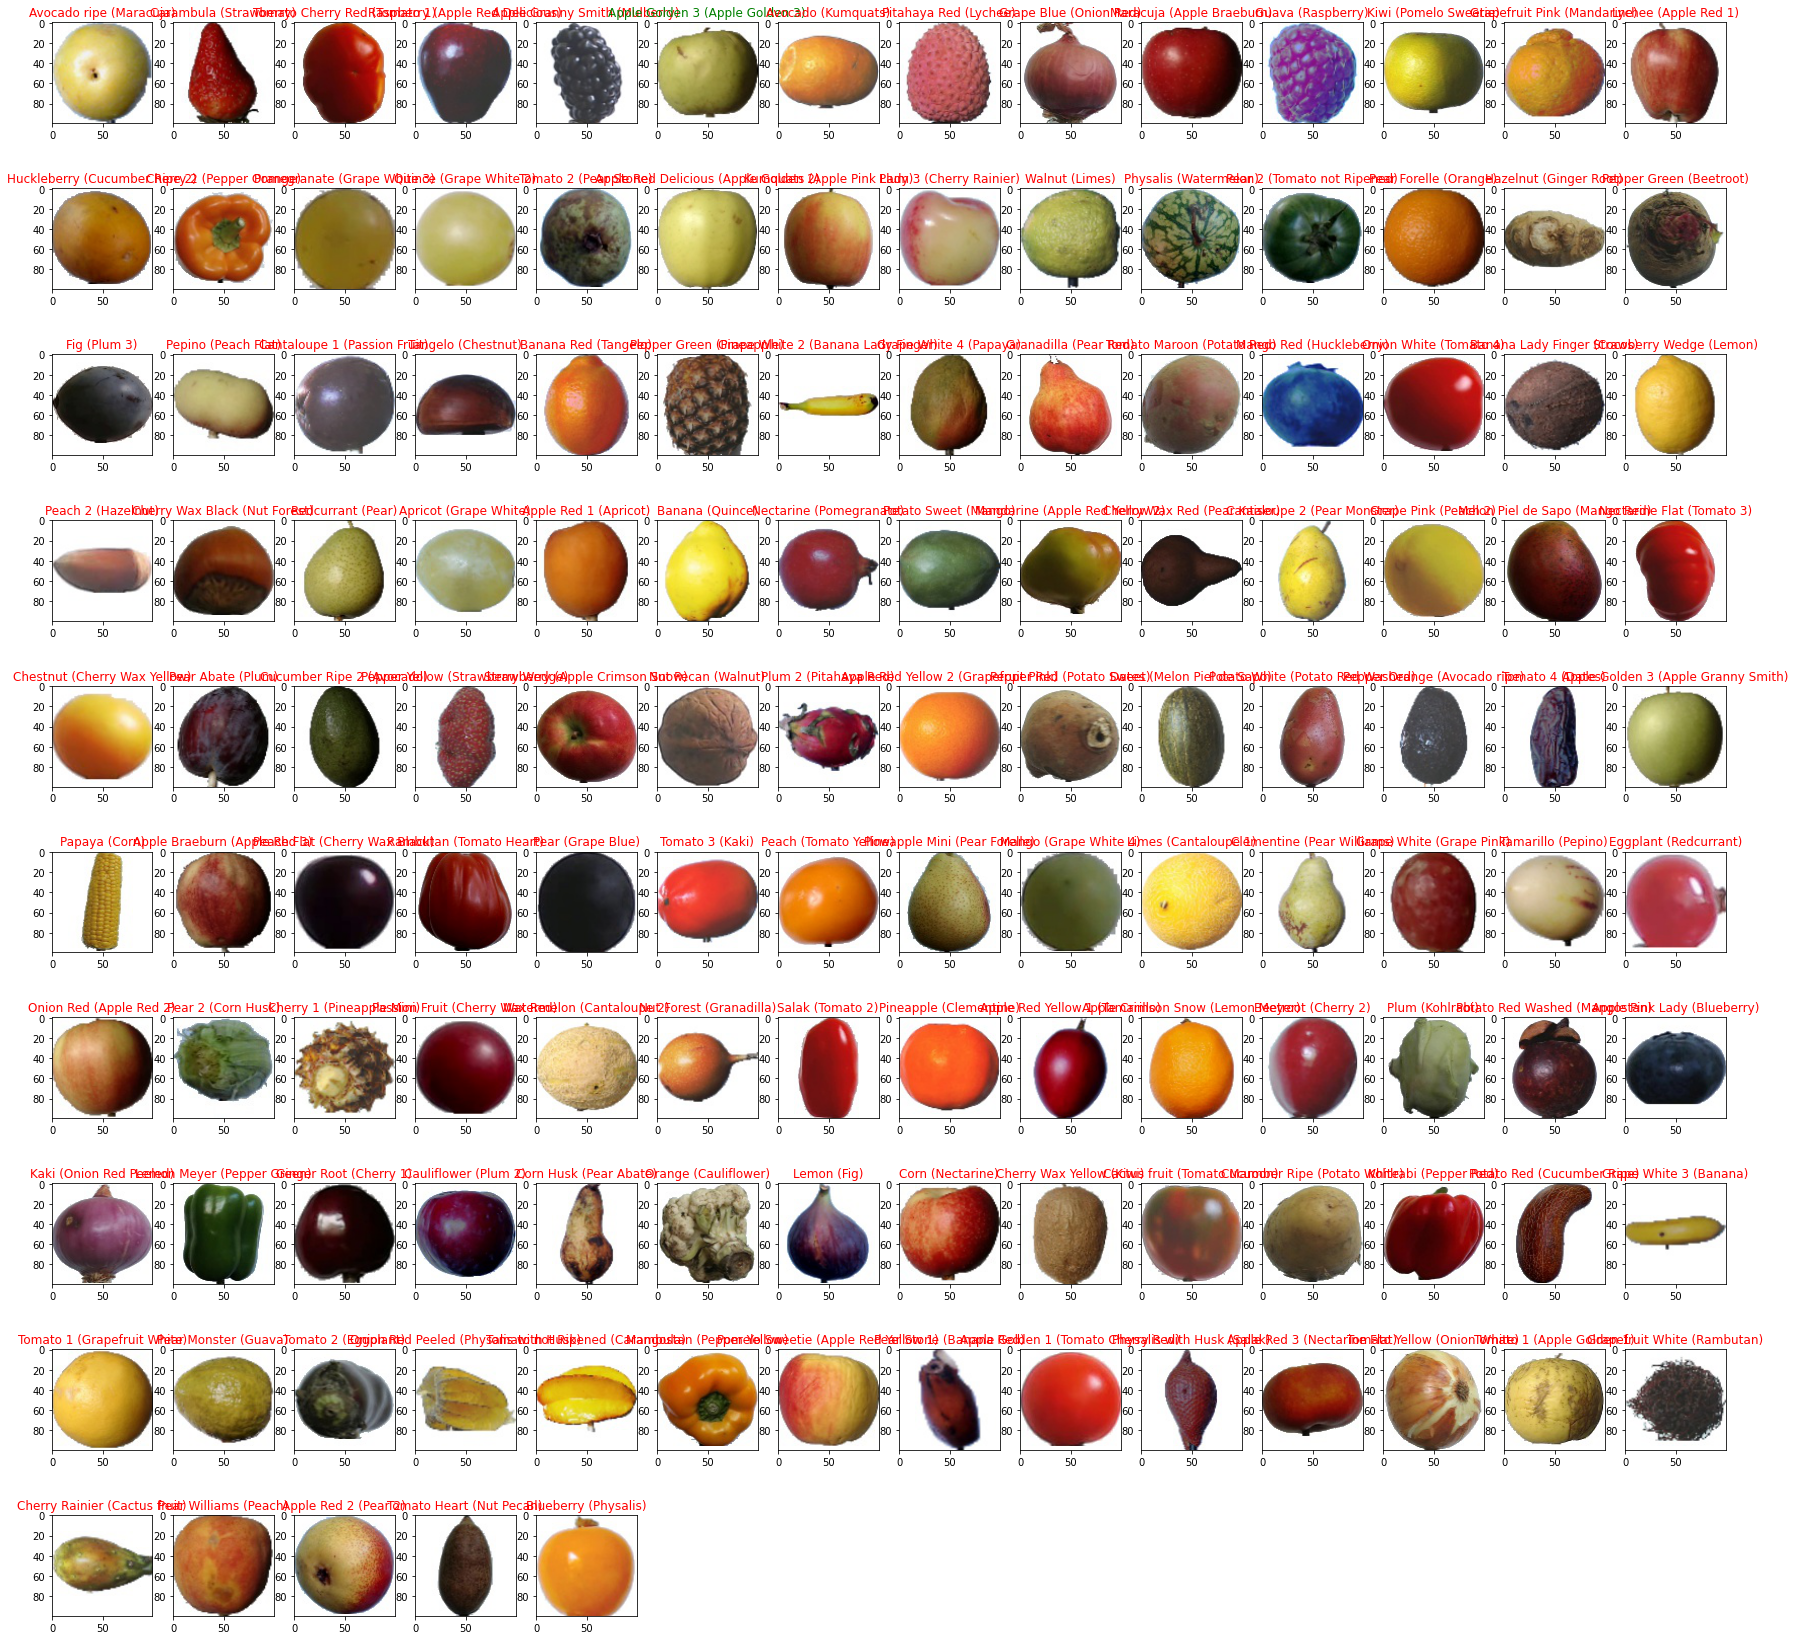

In [46]:
test_fruits_array = []
for i in range (number_classes):
  img = load_img(glob(test_path + classes[i] + "/*")[0])
  img_as_array = img_to_array(img)
  test_fruits_array.append(img_as_array)
test_fruits_array = np.array(test_fruits_array)
test_fruits_array = test_fruits_array.astype('float32')/255
predictions = model.predict(test_fruits_array)
predictions_labels = np.argmax(predictions, axis=1)
print(predictions_labels)
plt.figure(figsize = (30, 30))
for i in range(number_classes):
    plt.subplot(10, number_classes//10 + 1, i + 1)
    plt.imshow(np.squeeze(test_fruits_array[i]))
    plt.title("{} ({})".format(classes[predictions_labels[i]], classes[i]),
                 color=("green" if predictions_labels[i] == i else "red"))

# Tuning Model CNN
 I using Hyperas

In [52]:
!pip3 install hyperas
!pip3 install hyperopt

In [53]:
from hyperopt import Trials, STATUS_OK, tpe
import hyperas, hyperopt
from hyperas import optim
from hyperas.distributions import choice, uniform

In [54]:
def data():   
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                      shear_range=0.3, 
                                      horizontal_flip=True, 
                                      zoom_range=0.3)
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size = x.shape[:2], 
                                                    batch_size = batch_size,
                                                    shuffle=True, 
                                                    color_mode='rgb')
    val_generator = val_datagen.flow_from_directory(train_path, 
                                                  target_size = x.shape[:2], 
                                                  batch_size = batch_size,
                                                  shuffle=True, 
                                                  color_mode='rgb')
    return train_generator, val_generator

def create_model(train_generator, val_generator):
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape = x.shape))
    model.add(MaxPooling2D())

    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Flatten())
    model.add(Dense({{choice([256, 512,1024])}}, input_shape=x.shape[:2]))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))

    choiceval = {{choice(['three', 'two'])}}
    if choiceval == 'three':
      model.add(Dense({{choice([256, 512, 1024])}}))
      model.add(Activation('relu'))
      model.add(Dropout({{uniform(0, 1)}}))

    model.add(Dense(numberOfClass, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    batch_size = {{choice([32, 64, 128])}}
    result = model.fit_generator(generator = train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    epochs = 5,
                    validation_data = val_generator,
                    validation_steps = val_generator.samples // batch_size)
    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [61]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid = drive.ListFile({'q':"title='FruitClassificationProject_DeepLearning.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('FruitClassificationProject_DeepLearning.ipynb')

In [71]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

def data():  
  train_path = "files/fruits-360/Training/"
  test_path = "files/fruits-360/Test/"
  
  x_train, y_train,target_labels = load_dataset(train_path)
  x_test, y_test,_ = load_dataset(test_path)

  from keras.utils import np_utils
  y_train = np_utils.to_categorical(y_train,number_classes)
  y_test = np_utils.to_categorical(y_test,number_classes)

  x_train = np.array(convert_image_to_array(x_train))
  x_test = np.array(convert_image_to_array(x_test))
  
  x_train = x_train.astype('float32')/255
  x_test = x_test.astype('float32')/255
  return x_train, y_train, x_test, y_test

best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      notebook_name='FruitClassificationProject_DeepLearning',
                                      trials=Trials())
print("Evalutation of best performing model:")
print(best_model.evaluate_generator(generator=test_generator, 
                                      steps=test_generator.samples // batch_size))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    from google.colab import files
except:
    pass

try:
    import zipfile
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from glob import glob
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
except:
    pass

try:
    from operator import itemgetter
except:
    pass

try:
    import json
except:
    pass

try:
    from sklearn.metrics import classification_report
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    import hyperas, hyperopt
except:
    pass

try:
    from hyperas import optim
except

TypeError: ignored

# Conclusion

1. Dataset have 131 classes, with 67692 images in train dataset and 22688 images in test.
2. Classification the dataset using CNN take accuracy high level: 94%
3. Otherwise, loss is quite high, 31%, but f1-score is very high as well, 94%. I think it is overfitting, because I try predict some images(131 pics) is having 1/131 pic is correct. So I don't understand this. 
4. I fine-tuning model by using Hyperas. However, cannot, because having the error which is in Trials. I affort to find solution but nothing is matched :((